In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

#Regressoors
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from xgboost import XGBRegressor

#PCA
from sklearn.decomposition import RandomizedPCA, PCA
#MDS
from sklearn.manifold import MDS
#SNE
from sklearn.manifold import TSNE

#Train Test Split
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error as MSE

import statsmodels.api as sm
from statsmodels.stats.weightstats import *
from statsmodels.stats.descriptivestats import sign_test
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, interact_manual

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Проверка гипотезы
#### Проведем качественное (визуальное) и количественное (метрики качества регрессии) сравнение спектров Исходных и Scaled, с целью убедиться что основным источником информации является форма линии спектров

In [2]:
# Калибровка из номера канала в нм
chnl_to_nm = np.linspace(443.86,1007.41, 1024)

## 1) Исходные спектры

In [3]:
Data = pd.read_csv('20190318.txt', sep=' ')
Data = Data.iloc[:1024,4:-1].T
Vals = Data.iloc[0,:].values
Data.iloc[0,:] = map(lambda x : int(x), Vals)
Data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Spectrum1,80,62,61,28,25,55,44,32,45,47,...,921,913,879,893,893,852,868,865,869,874
Spectrum2,47,27,73,56,33,57,46,26,52,76,...,928,909,921,933,907,896,910,868,922,908
Spectrum3,63,47,49,37,62,13,24,48,60,46,...,934,940,929,946,968,909,960,914,939,953
Spectrum4,64,33,76,40,49,54,39,22,33,45,...,966,976,965,964,959,950,957,922,931,962
Spectrum5,38,55,79,53,86,64,47,42,28,17,...,886,864,894,882,886,869,868,851,878,867
Spectrum6,77,51,40,48,46,54,49,63,51,52,...,819,885,836,839,841,829,859,817,836,828
Spectrum7,38,47,40,56,52,57,45,44,31,65,...,803,812,822,816,821,806,793,785,806,805
Spectrum8,93,39,33,43,58,21,55,54,64,32,...,800,814,780,791,819,790,799,791,775,783
Spectrum9,61,53,56,55,30,47,51,52,36,48,...,794,780,761,770,764,777,778,728,760,774
Spectrum10,50,37,71,45,43,38,67,54,63,42,...,749,757,735,742,731,745,729,755,748,762


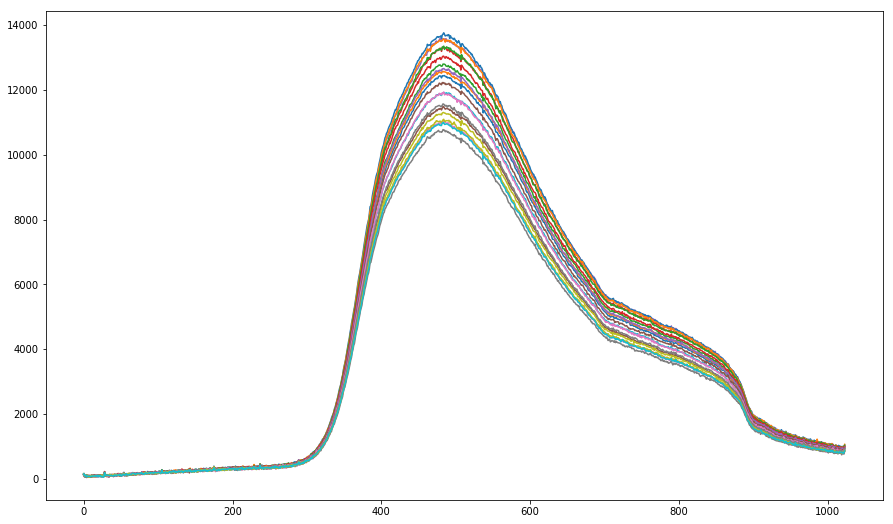

In [4]:
plt.figure(figsize=(15,9))
for i in range(20,40):
    plt.plot(range(Data.shape[1]) , Data.iloc[i,:].values)

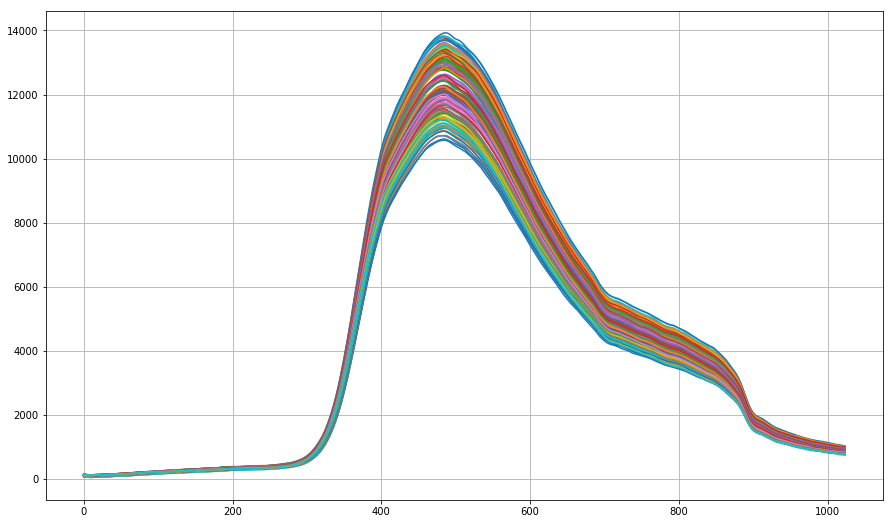

In [5]:
data_lowess_1 = list()
plt.figure(figsize=(15,9))
for i in range(Data.shape[0]) :
    x = range(Data.shape[1])
    y = Data.iloc[i].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.015)
    plt.plot(lowess[:,0], lowess[:,1])
    data_lowess_1.append(lowess[:,1])
plt.grid()
lowess_df = pd.DataFrame(np.array(data_lowess_1))

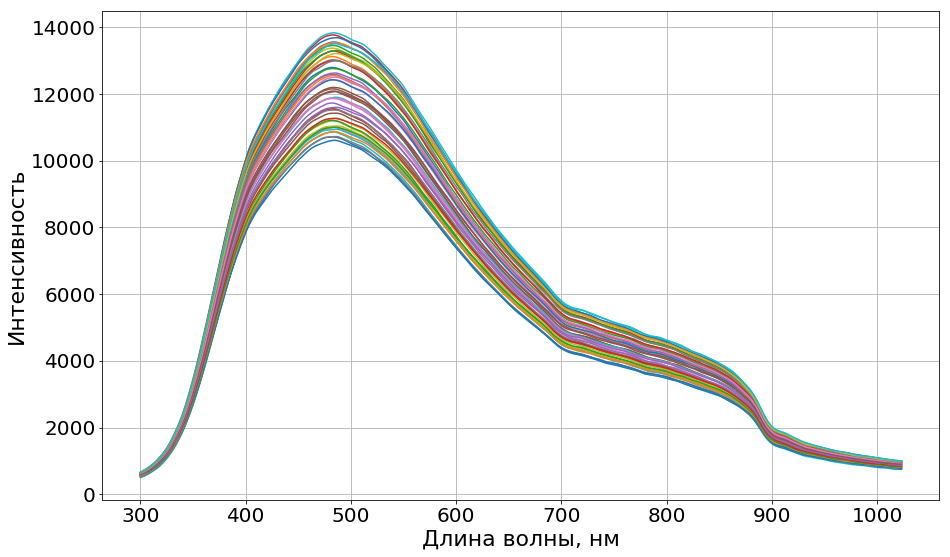

In [6]:
scaler = MinMaxScaler()
#for i in range(lowess_df.shape[0]):
scaler.fit(lowess_df.T)
scaled_lowess_df = pd.DataFrame(scaler.transform(lowess_df.T)).T

plt.figure(figsize=(15,9))
for i in range(50):
    plt.plot(range(300,1024) ,lowess_df.iloc[i,300:].values)
plt.xlabel(u'Длина волны, нм', fontsize=22)
plt.ylabel(u'Интенсивность', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title(u'Спектры пропускания при изменении pH образца №1', fontsize=20)
plt.grid()
plt.savefig('init_spectra.pdf')

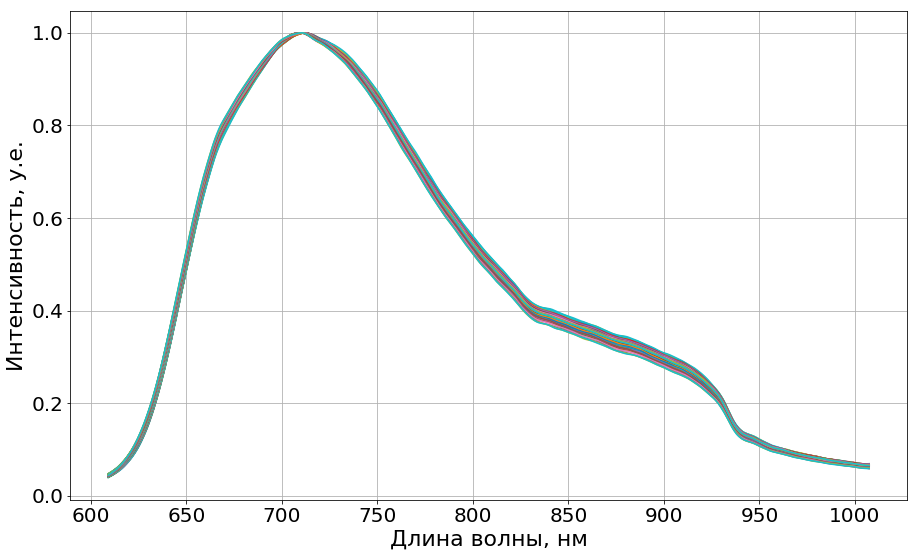

In [7]:
plt.figure(figsize=(15,9))
for i in range(scaled_lowess_df.shape[0]):
    plt.plot(chnl_to_nm[300:] ,scaled_lowess_df.iloc[i,300:].values)
plt.xlabel(u'Длина волны, нм', fontsize=22)
plt.ylabel(u'Интенсивность, у.е.', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title(u'Спектры пропускания при изменении pH образца №1', fontsize=20)
plt.grid()
plt.savefig('scaled_spectra.pdf')

In [8]:
pH = np.array([3.65]*10+[3.64]*10+[3.63]*10+[3.62]*10+[3.61]*10+[3.60]*10+[3.59]*10+[3.58]*10+[3.56]*10+[3.53]*10+[3.52]*10+[3.50]*10+[3.48]*10)
lowess_df['pH'] = pH
scaled_lowess_df['pH'] = pH

# ВАРИАТИВНО
lowess_df.to_csv('lowess_df.csv', index=0)
scaled_lowess_df.to_csv('scaled_lowess_df.csv', index=0)

## PCA для исходных спектров

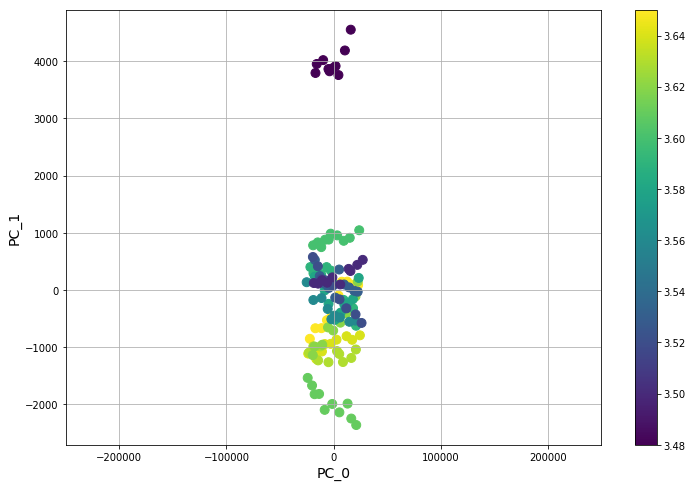

In [9]:
pca_model = PCA(n_components=3)
pca_data = pd.DataFrame(pca_model.fit_transform(lowess_df.drop('pH', axis=1)))
pca_data['pH'] = lowess_df.pH.values

plt.figure(figsize=(12,8))
#plt.title(u'Проекции исходных спектров', fontsize=20)
plt.scatter(pca_data.iloc[:,0], pca_data.iloc[:,1], c=pca_data.pH.values[:], s=80)
plt.xlabel('PC_0', fontsize=14)
plt.ylabel('PC_1', fontsize=14)
plt.colorbar()
plt.xlim(-250000,250000)
#plt.ylim(-0.2,0.2)
plt.grid()
plt.savefig('pca_init.pdf')

In [10]:
# Сохраним PCA исходных спектров 
pca_data.to_csv('hyp_of_shape_init_specs.csv', sep=',')

## PCA для scaled спектров

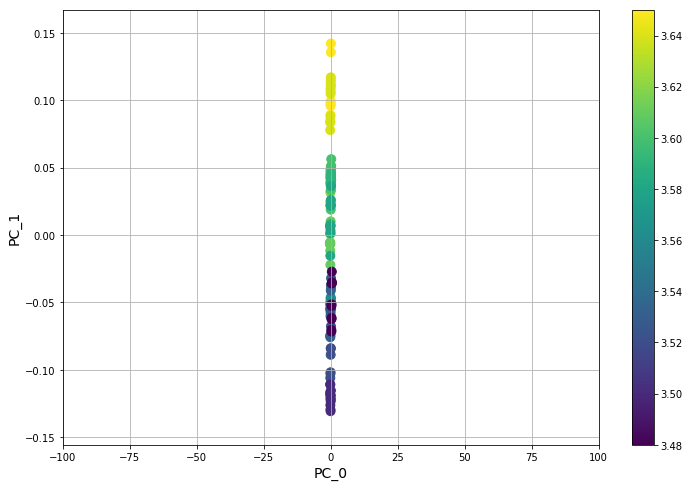

In [11]:
pca_model = PCA(n_components=3)
pca_scaled_data = pd.DataFrame(pca_model.fit_transform(scaled_lowess_df.drop('pH', axis=1).iloc[:,300:]))
pca_scaled_data['pH'] = scaled_lowess_df.pH.values

plt.figure(figsize=(12,8))
#plt.title(u'Проекции для отмасштабированных спектров', fontsize=20)
plt.scatter(pca_scaled_data.iloc[:,0], pca_scaled_data.iloc[:,1], c=pca_scaled_data.pH.values[:], s=80)
plt.xlabel('PC_0', fontsize=14)
plt.ylabel('PC_1', fontsize=14)
plt.colorbar()
plt.xlim(-100,100)
#plt.ylim(-0.2,0.2)
plt.grid()
plt.savefig('pca_scaled.pdf')

In [12]:
sum(pca_model.explained_variance_ratio_)

0.9865041321681948

In [13]:
# Сохраним PCA scaled спектров 
pca_scaled_data.to_csv('hyp_of_shape_scaled_specs.csv', sep=',')

## Регрессия
### 1) Случайные выборки исходных спектров

Test Data :  [3.65 3.52 3.48 3.48 3.58 3.62 3.52 3.63 3.59 3.5  3.64 3.62 3.63 3.65
 3.65 3.65 3.64 3.56 3.6  3.59 3.6  3.59 3.58 3.5  3.52 3.63 3.53 3.48
 3.62 3.61 3.64 3.62 3.52 3.63 3.65 3.48 3.5  3.59 3.58]
Predictions :  [3.65 3.52 3.48 3.48 3.58 3.62 3.52 3.63 3.58 3.52 3.64 3.62 3.63 3.65
 3.65 3.65 3.64 3.55 3.6  3.6  3.6  3.58 3.57 3.51 3.5  3.63 3.55 3.48
 3.62 3.61 3.64 3.63 3.52 3.63 3.65 3.48 3.5  3.56 3.59]
Delta :  [ 0.    0.    0.    0.    0.    0.    0.    0.    0.01 -0.02  0.    0.
  0.    0.    0.    0.    0.    0.01  0.   -0.01  0.    0.01  0.01 -0.01
  0.02  0.   -0.02  0.    0.    0.    0.   -0.01  0.    0.    0.    0.
  0.    0.03 -0.01]
Mean Squared Error :  0.0086


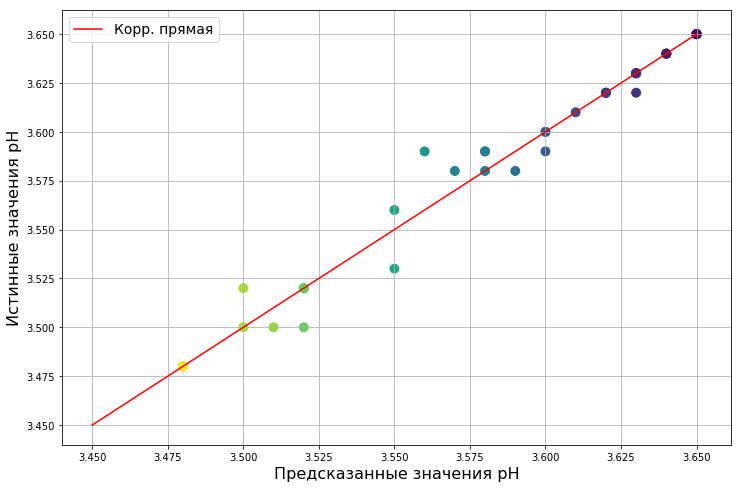

In [14]:
train_data, test_data, train_target, test_target = train_test_split(pca_data.drop('pH', axis=1), pca_data.pH,
                                                                   test_size=0.3, random_state=123)

regressor = GradientBoostingRegressor(learning_rate=0.07) #GradientBoostingRegressor(learning_rate=0.07) #LinearRegression()
regressor.fit(train_data, train_target)
preds = regressor.predict(test_data)
 
print 'Test Data : ', test_target.values
print 'Predictions : ', preds.round(2)
print 'Delta : ', test_target.values - preds.round(2)
print 'Mean Squared Error : ', np.sqrt(MSE(test_target.values, preds)).round(4)

plt.figure(figsize=(12,8))
plt.plot(np.arange(3.45,3.7,0.1), np.arange(3.45,3.7,0.1), c='r', label=u'Корр. прямая')
plt.scatter(preds.round(2) , test_target.values, c=1-(preds-preds.min())/preds.max(), s=80)
plt.xlabel(u'Предсказанные значения pH', fontsize=16)
plt.ylabel(u'Истинные значения pH', fontsize=16)
#plt.title('Theory VS Experiment : Initial', fontsize=20)

plt.grid()
plt.legend(loc='upper left', fontsize=14)
plt.savefig('reg_res_init.pdf')

In [18]:
mse_array = []
scores = []
for i in range(100):
    train_data, test_data, train_target, test_target = train_test_split(pca_data.drop('pH', axis=1), pca_data.pH,
                                                                   test_size=0.3, random_state=i)

    regressor = GradientBoostingRegressor(learning_rate=0.07) #LinearRegression() #GradientBoostingRegressor(learning_rate=0.07)
    regressor.fit(train_data, train_target)
    preds = regressor.predict(test_data)
    
    mse_array.append(np.sqrt(MSE(test_target.values, preds)).round(6))
    scores.append(regressor.score(test_data, test_target))
    
print 'MSE : ', mse_array[:20]
print 
print 'Corrs : ', scores[:20]
print 
print 'Среднее MSE по 100 случайным выборкам : ', np.sqrt(np.mean(mse_array)).round(4)
print 'Средняя корреляция по 100 случайным выборкам : ', np.mean(scores).round(4)

 MSE :  [0.006702, 0.008161, 0.006595, 0.005664, 0.008144, 0.008217, 0.006082, 0.011046, 0.018232, 0.006971, 0.005636, 0.009039, 0.006779, 0.010369, 0.009774, 0.007951, 0.010117, 0.008387, 0.011265, 0.013249]

Corrs :  [0.983098600543075, 0.9730633751168871, 0.9854886058911071, 0.9898204506728779, 0.9751690705426524, 0.9748003156726335, 0.9857380569699449, 0.9587386566957673, 0.8832035898718384, 0.9779897110194932, 0.988577054445575, 0.9719611953800539, 0.9870654863860909, 0.9551947875434035, 0.9626623531754559, 0.9751648396823386, 0.9653112059341801, 0.9690177032447889, 0.9555043732520702, 0.9401383186344152]

Среднее MSE по 100 случайным выборкам :  0.0956
Средняя корреляция по 100 случайным выборкам :  0.9664


### 2) Случайные выборки отмасштабированных спектров

Test Data :  [3.65 3.52 3.48 3.48 3.58 3.62 3.52 3.63 3.59 3.5  3.64 3.62 3.63 3.65
 3.65 3.65 3.64 3.56 3.6  3.59 3.6  3.59 3.58 3.5  3.52 3.63 3.53 3.48
 3.62 3.61 3.64 3.62 3.52 3.63 3.65 3.48 3.5  3.59 3.58]
Predictions :  [3.65 3.54 3.48 3.48 3.58 3.62 3.52 3.6  3.6  3.51 3.65 3.62 3.62 3.64
 3.64 3.65 3.64 3.55 3.59 3.59 3.63 3.59 3.59 3.5  3.52 3.63 3.53 3.48
 3.61 3.61 3.64 3.63 3.52 3.63 3.64 3.48 3.5  3.62 3.58]
Delta :  [ 0.   -0.02  0.    0.    0.    0.    0.    0.03 -0.01 -0.01 -0.01  0.
  0.01  0.01  0.01  0.    0.    0.01  0.01  0.   -0.03  0.   -0.01  0.
  0.    0.    0.    0.    0.01  0.    0.   -0.01  0.    0.    0.01  0.
  0.   -0.03  0.  ]
Mean Squared Error :  0.01


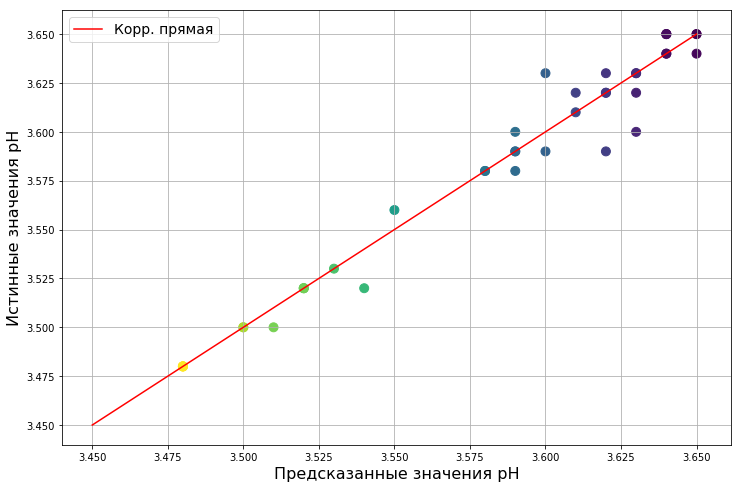

In [16]:
train_data, test_data, train_target, test_target = train_test_split(pca_scaled_data.drop('pH', axis=1),
                                                                    pca_scaled_data.pH,
                                                                   test_size=0.3, random_state=123)

regressor = GradientBoostingRegressor(learning_rate=0.07) #GradientBoostingRegressor(learning_rate=0.07) #LinearRegression()
regressor.fit(train_data, train_target)
preds = regressor.predict(test_data)

print 'Test Data : ', test_target.values
print 'Predictions : ', preds.round(2)
print 'Delta : ', test_target.values - preds.round(2)
print 'Mean Squared Error : ', np.sqrt(MSE(test_target.values, preds)).round(4)

plt.figure(figsize=(12,8))
plt.plot(np.arange(3.45,3.7,0.1), np.arange(3.45,3.7,0.1), c='r', label=u'Корр. прямая')
plt.scatter(preds.round(2) , test_target.values, c=1-(preds-preds.min())/preds.max(), s=80)
plt.xlabel(u'Предсказанные значения pH', fontsize=16)
plt.ylabel(u'Истинные значения pH', fontsize=16)
#plt.title('Theory VS Experiment : Scaled', fontsize=20)

plt.grid()
plt.legend(loc='upper left', fontsize=14)
plt.savefig('reg_res_scaled.pdf')

In [19]:
mse_scaled_array = []
scores_scaled = []
for i in range(100):
    train_data, test_data, train_target, test_target = train_test_split(pca_scaled_data.drop('pH', axis=1),
                                                                        pca_scaled_data.pH,
                                                                   test_size=0.3, random_state=i)

    regressor = GradientBoostingRegressor(learning_rate=0.07) #LinearRegression() #GradientBoostingRegressor(learning_rate=0.07)
    regressor.fit(train_data, train_target)
    preds = regressor.predict(test_data)
    
    mse_scaled_array.append(np.sqrt(MSE(test_target.values, preds)).round(6))
    scores_scaled.append(regressor.score(test_data, test_target))
    
print 'MSE : ', mse_diff_array[:20]
print 
print 'Corrs : ', scores_diff[:20]
print 
print 'Среднее MSE по 100 случайным выборкам : ', np.sqrt(np.mean(mse_diff_array)).round(4)
print 'Средняя корреляция по 100 случайным выборкам : ', np.mean(scores_diff).round(4)

MSE : 

NameError: name 'mse_diff_array' is not defined

### Для каждого из случаев (случайных выборок) соберем набор значений MSE и степени корреляции и сравним распределения



In [20]:
scores_df = pd.DataFrame([scores, scores_scaled]).T
scores_df.columns = [u'Исходные', u'Scaled']

       Исходные   Scaled
count   100.000  100.000
mean      0.966    0.957
std       0.025    0.025
min       0.838    0.871
25%       0.960    0.943
50%       0.972    0.966
75%       0.983    0.976
max       0.994    0.986


/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


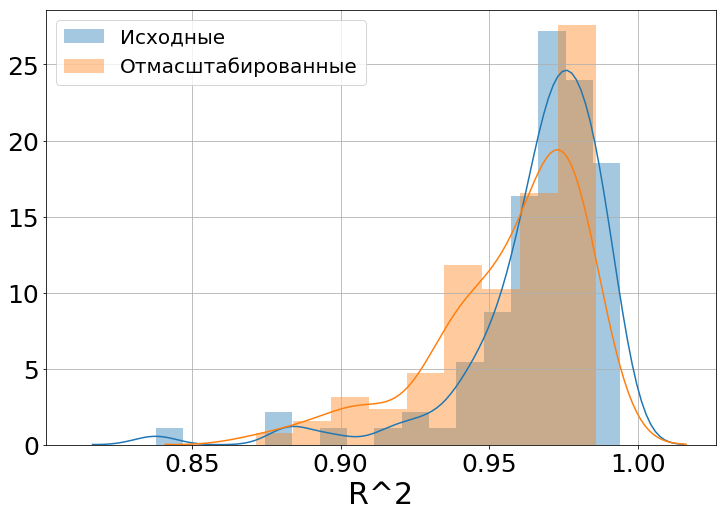

In [49]:
print scores_df.describe().round(3)

plt.figure(figsize=(12,8))
sns.distplot(scores_df.iloc[:,0], label=u'Исходные')
sns.distplot(scores_df.iloc[:,1], label=u'Отмасштабированные')
#plt.title(u'Значения корреляции', fontsize=28)
plt.xlabel(u'R^2', fontsize=30)

plt.xticks(np.arange(0.8,1.05,0.05),fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(0.801)
plt.grid()
plt.legend(loc = 'upper left', fontsize=20)
plt.savefig('dist_plot_corrs.pdf')
plt.show()


In [22]:
mse_df = pd.DataFrame([mse_array, mse_scaled_array]).T
mse_df.columns = [u'Исходные', u'Scaled']

       Исходные    Scaled
count  100.0000  100.0000
mean     0.0091    0.0105
std      0.0029    0.0028
min      0.0040    0.0065
25%      0.0074    0.0083
50%      0.0085    0.0099
75%      0.0105    0.0123
max      0.0207    0.0191


/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


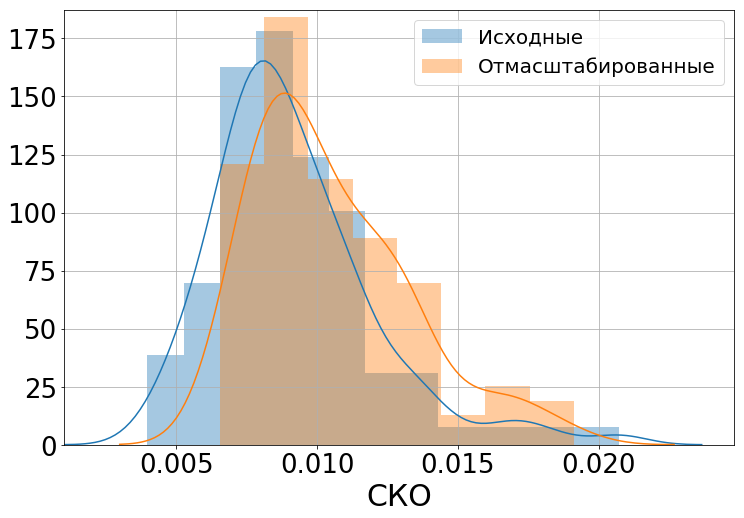

In [50]:
print mse_df.describe().round(4)

plt.figure(figsize=(12,8))
sns.distplot(mse_df.iloc[:,0], label=u'Исходные')
sns.distplot(mse_df.iloc[:,1], label=u'Отмасштабированные')
#plt.title('RMSE', fontsize=28)
plt.xlim(0.001)
plt.xlabel(u'СКО', fontsize=30)

plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid()
plt.legend(loc = 'upper right', fontsize=20)
plt.savefig('dist_plot_rmse.pdf')

#### Визуально оба распределения похожи. Проверим эти распределения на "нормальность"

In [86]:
stats.distributions.chi2.ppf

<bound method chi2_gen.ppf of <scipy.stats._continuous_distns.chi2_gen object at 0x1819ac9450>>

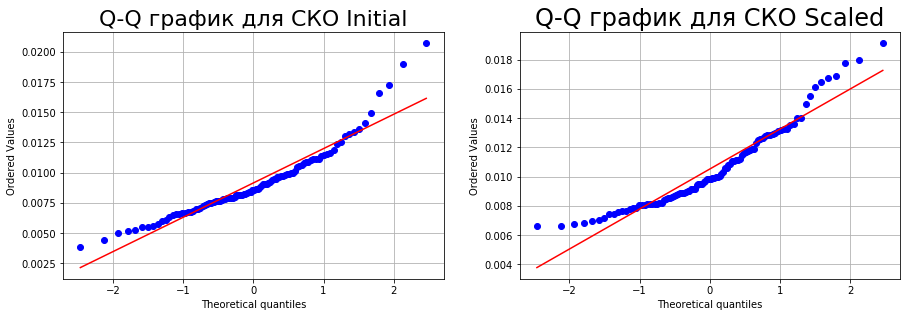

In [107]:
# Для MSE

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
#stats.probplot(mse_df.iloc[:,0], dist=stats.distributions.chi2, sparams=(3), plot=plt)
stats.probplot(mse_df.iloc[:,0], dist='norm', plot=plt)
# plt.xlabel(u'Теоретические квантили', fontsize=20)
# plt.ylabel(u'Упорядоченные значения', fontsize=20)
plt.title(u'Q-Q график для СКО Initial', fontsize=22)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.grid()

plt.subplot(2,2,2)
#stats.probplot(mse_df.iloc[:,1], dist=stats.distributions.chi2, sparams=(3), plot=plt)
stats.probplot(mse_df.iloc[:,1], dist='norm', plot=plt)
# plt.xlabel(u'Теоретические квантили', fontsize=20)
# plt.ylabel(u'Упорядоченные значения', fontsize=20)
plt.title(u'Q-Q график для СКО Scaled', fontsize=24)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.grid()
plt.savefig('qq_plot_rmse.pdf')
plt.show()

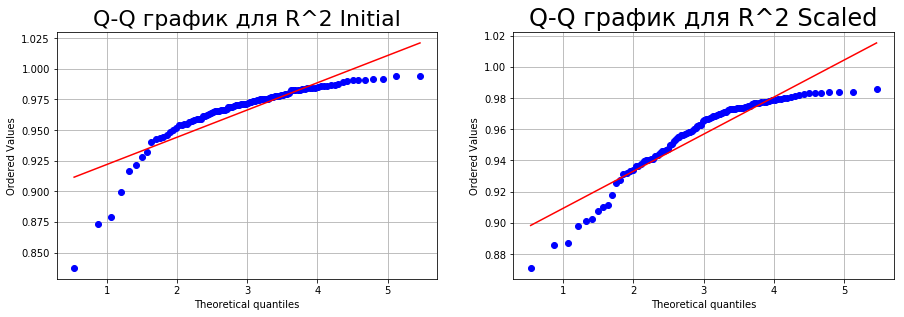

In [106]:
# Для корреляций

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
stats.probplot(scores_df.iloc[:,0], dist='norm', sparams=(3), plot=plt)
plt.title(u'Q-Q график для R^2 Initial', fontsize=22)
plt.grid()

plt.subplot(2,2,2)
stats.probplot(scores_df.iloc[:,1], dist='norm', sparams=(3), plot=plt)
plt.title(u'Q-Q график для R^2 Scaled', fontsize=24)
plt.grid()
plt.savefig('qq_plot_r2.pdf')
plt.show()


#### И посмотрим на формальные тесты

In [266]:
print "p-value for MSE of Initial specs : %f" % stats.shapiro(mse_df.iloc[:,0])[1]
print "p-value for MSE of Scaled specs : %f" % stats.shapiro(mse_df.iloc[:,1])[1]

p-value for MSE of Initial specs : 0.000009
p-value for MSE of Scaled specs : 0.000020


In [267]:
print "p-value for Scores of Initial specs : %f" % stats.shapiro(scores_df.iloc[:,0])[1]
print "p-value for Scores of Scaled specs : %f" % stats.shapiro(scores_df.iloc[:,1])[1]

p-value for Scores of Initial specs : 0.000000
p-value for Scores of Scaled specs : 0.000000


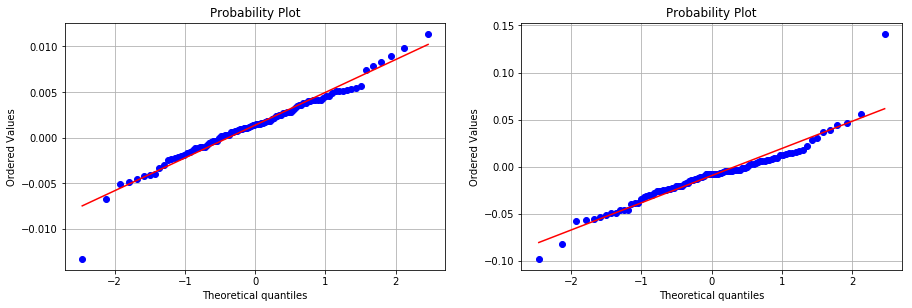

In [78]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
stats.probplot(mse_df.iloc[:,1] - mse_df.iloc[:,0], dist = "norm", plot = plt)
plt.grid()
plt.subplot(2,2,2)
stats.probplot(scores_df.iloc[:,1] - scores_df.iloc[:,0], dist = "norm", plot = plt)
plt.grid()

plt.show()

In [79]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(mse_df.iloc[:,1] - mse_df.iloc[:,0])
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(scores_df.iloc[:,1] - scores_df.iloc[:,0])

Shapiro-Wilk normality test, W-statistic: 0.970191, p-value: 0.022860
Shapiro-Wilk normality test, W-statistic: 0.918000, p-value: 0.000011


In [80]:
print stats.ttest_rel(mse_df.iloc[:,0], mse_df.iloc[:,1])
print stats.ttest_rel(scores_df.iloc[:,0], scores_df.iloc[:,1])

Ttest_relResult(statistic=-3.7953928592072517, pvalue=0.0002540856461582523)
Ttest_relResult(statistic=3.137379065651272, pvalue=0.002245592941605661)


In [230]:
print 'p-value for MSE : ', stats.wilcoxon(mse_df.iloc[:,0], mse_df.iloc[:,1])[1].round(6)
print 'p-values for Scores : ',stats.wilcoxon(scores_df.iloc[:,0], scores_df.iloc[:,1])[1].round(6)

p-value for MSE :  6e-05
p-values for Scores :  9.9e-05


## Перестановочный критерий

In [26]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(map(lambda x: x - mean, sample))
    return t_stat

In [27]:
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = map(lambda x: x - mean, sample)
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


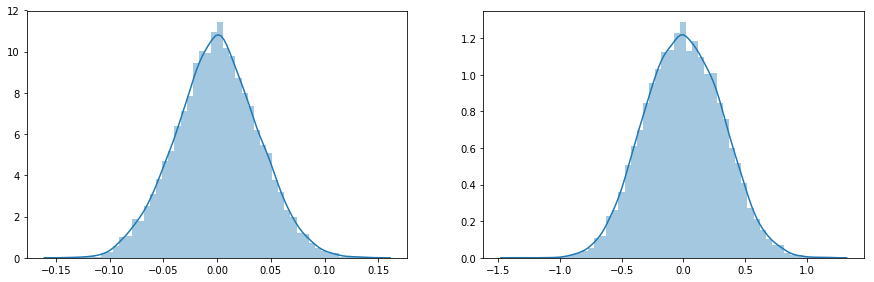

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.distplot(permutation_zero_distr_1sample(mse_df.iloc[:,0] - mse_df.iloc[:,1], 0., 
                               max_permutations = 10000))
plt.subplot(2,2,2)
sns.distplot(permutation_zero_distr_1sample(scores_df.iloc[:,0] - scores_df.iloc[:,1], 0., 
                               max_permutations = 10000))

plt.show()

In [29]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [47]:
print "p-value: %f" % permutation_test(mse_df.iloc[:,1] - mse_df.iloc[:,0], 0., 
                               max_permutations = 10000, alternative='greater')

p-value: 0.000100


In [48]:
print "p-value: %f" % permutation_test(scores_df.iloc[:,0] - scores_df.iloc[:,1], 0., 
                               max_permutations = 10000, alternative='greater')

p-value: 0.000800
